In [2]:
import logging
import os
import shutil
import sys
import time
import tempfile
from glob import glob
from tqdm import tqdm
import pickle

import pandas as pd
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import (
    ITKReader,
    NumpyReader,
)
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    Flipd,
    Lambdad,
    LoadImaged,
    RandAdjustContrastd, #check whether necessary
    RandFlipd,
    RandAffined,
    Resize,
    Resized,
    Rotate90d,
    ScaleIntensity,
    ScaleIntensityd,
    ToNumpy,
    ToTensor,
    ToTensord,
)
from monai.utils import first

from matplotlib import pylab as plt
from skimage.io import imread

import itk

monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)

MONAI version: 1.0.1
Numpy version: 1.22.4
Pytorch version: 1.13.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: E:\Users\BerkOlcay\anaconda3\envs\DL\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.14.0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.4.1
transformers version: 4.24.0
mlflow version: 1.30.0
pynrrd version: 0.4.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

Device is cuda


In [3]:

def draw_segmented_area(frame_rgb, 
                        pupil_map_masked, 
                        iris_map_masked, 
                        glints_map_masked, 
                        visible_map_masked, 
                        irrelevant_map_masked, 
                        ax=None):
    # Plot segmented area
    #fig, ax = plt.subplots(figsize=(3.2,2.4))
    alpha=0.4
    fig_created = False
    if ax is None:
        fig = plt.figure(figsize=(3.2,2.4))
        #canvas = FigureCanvas(fig)
        ax = fig.subplots()
        fig_created = True
    ax.imshow(frame_rgb)#, vmax=1, vmin=0, cmap="gray")
    ax.imshow(np.ma.masked_where(visible_map_masked<0.5,visible_map_masked), cmap="spring", vmax=1, vmin=0, alpha=alpha)
    ax.imshow(np.ma.masked_where(iris_map_masked<0.5,iris_map_masked), cmap="GnBu", vmax=1, vmin=0, alpha=alpha)
    ax.imshow(np.ma.masked_where(pupil_map_masked<0.5,pupil_map_masked), cmap="OrRd", vmax=1, vmin=0, alpha=alpha)
    ax.imshow(np.ma.masked_where(glints_map_masked<0.5,glints_map_masked), cmap="cool", vmax=1, vmin=0, alpha=alpha)
    ax.imshow(np.ma.masked_where(irrelevant_map_masked<0.5,irrelevant_map_masked), cmap="Wistia", vmax=1, vmin=0, alpha=alpha)
    ax.axis('off')
    if fig_created:
        fig.tight_layout()
        fig.canvas.draw()
        plt.show()
        
def draw_segmented_areas_separately(frame_rgb, 
                        pupil_map_masked, 
                        iris_map_masked, 
                        glints_map_masked, 
                        visible_map_masked, 
                        irrelevant_map_masked, 
                        ax=None):
    # Plot segmented area
    #fig, ax = plt.subplots(figsize=(3.2,2.4))
    alpha=0.4
    fig_created = False
    if ax is None:
        fig = plt.figure(figsize=(32, 24))
        #canvas = FigureCanvas(fig)
        ax = fig.subplots(1,5)
        fig_created = True
    ax[0].imshow(np.ma.masked_where(visible_map_masked<0.5,visible_map_masked), cmap="spring", vmax=1, vmin=0)
    ax[0].axis('off')
    
    ax[1].imshow(np.ma.masked_where(iris_map_masked<0.5,iris_map_masked), cmap="GnBu", vmax=1, vmin=0)
    ax[1].axis('off')
    
    ax[2].imshow(np.ma.masked_where(pupil_map_masked<0.5,pupil_map_masked), cmap="OrRd", vmax=1, vmin=0)
    ax[2].axis('off')
    
    ax[3].imshow(np.ma.masked_where(glints_map_masked<0.5,glints_map_masked), cmap="cool", vmax=1, vmin=0)
    ax[3].axis('off')
    
    ax[4].imshow(np.ma.masked_where(irrelevant_map_masked<0.5,irrelevant_map_masked), cmap="Wistia", vmax=1, vmin=0)
    ax[4].axis('off')
    if fig_created:
        fig.tight_layout()
        fig.canvas.draw()
        plt.show()
        

def draw_segmented_pupil(frame_rgb, pupil_map_masked, ax=None):
    # Plot segmented area
    #fig, ax = plt.subplots(figsize=(3.2,2.4))
    alpha=0.4
    fig_created = False
    if ax is None:
        fig = plt.figure(figsize=(3.2,2.4))
        #canvas = FigureCanvas(fig)
        ax = fig.subplots()
        fig_created = True
    ax.imshow(frame_rgb)#, vmax=1, vmin=0, cmap="gray")
    ax.imshow(np.ma.masked_where(pupil_map_masked<0.5,pupil_map_masked), cmap="OrRd", vmax=1, vmin=0, alpha=alpha)
    ax.axis('off')
    if fig_created:
        fig.tight_layout()
        fig.canvas.draw()
        plt.show()
        
def draw_segmented_iris(frame_rgb, iris_map_masked, ax=None):
    # Plot segmented area
    #fig, ax = plt.subplots(figsize=(3.2,2.4))
    alpha=0.4
    fig_created = False
    if ax is None:
        fig = plt.figure(figsize=(3.2,2.4))
        #canvas = FigureCanvas(fig)
        ax = fig.subplots()
        fig_created = True
    ax.imshow(frame_rgb)#, vmax=1, vmin=0, cmap="gray")
    ax.imshow(np.ma.masked_where(iris_map_masked<0.5,iris_map_masked), cmap="GnBu", vmax=1, vmin=0, alpha=alpha)
    ax.axis('off')
    if fig_created:
        fig.tight_layout()
        fig.canvas.draw()
        plt.show()
        
def draw_segmented_glints(frame_rgb, glints_map_masked, ax=None):
    # Plot segmented area
    #fig, ax = plt.subplots(figsize=(3.2,2.4))
    alpha=0.4
    fig_created = False
    if ax is None:
        fig = plt.figure(figsize=(3.2,2.4))
        #canvas = FigureCanvas(fig)
        ax = fig.subplots()
        fig_created = True
    ax.imshow(frame_rgb)#, vmax=1, vmin=0, cmap="gray")
    ax.imshow(np.ma.masked_where(glints_map_masked<0.5,glints_map_masked), cmap="cool", vmax=1, vmin=0, alpha=alpha)
    ax.axis('off')
    if fig_created:
        fig.tight_layout()
        fig.canvas.draw()
        plt.show()
        
def draw_segmented_visible(frame_rgb, visible_map_masked, ax=None):
    # Plot segmented area
    #fig, ax = plt.subplots(figsize=(3.2,2.4))
    alpha=0.4
    fig_created = False
    if ax is None:
        fig = plt.figure(figsize=(3.2,2.4))
        #canvas = FigureCanvas(fig)
        ax = fig.subplots()
        fig_created = True
    ax.imshow(frame_rgb)#, vmax=1, vmin=0, cmap="gray")
    ax.imshow(np.ma.masked_where(visible_map_masked<0.5,visible_map_masked), cmap="spring", vmax=1, vmin=0, alpha=alpha)
    ax.axis('off')
    if fig_created:
        fig.tight_layout()
        fig.canvas.draw()
        plt.show()

pn_code = 'E:\\Users\\BerkOlcay\\DeepVOG3D\\DeepVOG3D\\PYTHON'
pn_data = 'E:\\Users\\BerkOlcay\\DeepVOG3D\\DeepVOG3D\\data\\data_dv3d_monai_QA'

df = pd.read_csv(os.path.join(pn_code,'df_dv3d_monai_files.csv'), index_col=0)

# set up dataset splits and dict-lists
check_idxs = np.arange(0,df.shape[0])

check_files = [{"img": os.path.join(pn_data, fn_img), "seg": os.path.join(pn_data, fn_seg)} for fn_img, fn_seg in zip(df.fn_img[check_idxs], df.fn_seg_maps[check_idxs])]

print(f'df.columns:\n {df.columns.tolist()}')
df.head()

df.columns:
 ['fn_img', 'fn_qa_img', 'fn_annotation', 'fn_seg_maps', 'tag_dataset']


,fn_img,fn_qa_img,fn_annotation,fn_seg_maps,tag_dataset
0,12451_ubiris2_C107_S1_I7_000000.tiff,12451_ubiris2_C107_S1_I7_000000_seg_qa.png,12451_ubiris2_C107_S1_I7_000000.txt,12451_ubiris2_C107_S1_I7_000000_seg_maps.pkl,ubiris2
1,12452_ubiris2_C133_S1_I4_000000.tiff,12452_ubiris2_C133_S1_I4_000000_seg_qa.png,12452_ubiris2_C133_S1_I4_000000.txt,12452_ubiris2_C133_S1_I4_000000_seg_maps.pkl,ubiris2
2,12453_ubiris2_C79_S2_I2_000000.tiff,12453_ubiris2_C79_S2_I2_000000_seg_qa.png,12453_ubiris2_C79_S2_I2_000000.txt,12453_ubiris2_C79_S2_I2_000000_seg_maps.pkl,ubiris2
3,12454_ubiris2_C390_S1_I15_000000.tiff,12454_ubiris2_C390_S1_I15_000000_seg_qa.png,12454_ubiris2_C390_S1_I15_000000.txt,12454_ubiris2_C390_S1_I15_000000_seg_maps.pkl,ubiris2
4,12455_ubiris2_C85_S1_I1_000000.tiff,12455_ubiris2_C85_S1_I1_000000_seg_qa.png,12455_ubiris2_C85_S1_I1_000000.txt,12455_ubiris2_C85_S1_I1_000000_seg_maps.pkl,ubiris2


In [4]:
def convert_overlapping_to_one_hot():
    print ("iterating data")
    for index, item in enumerate(check_files):
        with open( item["seg"], 'rb') as file:
            arr = pickle.load(file)
            pupil_map_masked, iris_map_masked, visible_map_masked, glints_map_masked, = tuple([np.squeeze(arr[c,:,:]) for c in [0,1,2,3]])
        
            # ideally this should be the operation to separate the segmentations, but there are some wrongly labeled imgs
            # visible_map_masked = visible_map_masked - iris_map_masked - glints_map_masked
            
            # I want to get relative complement (visible_map_masked\others). That is visible_map_masked intersected with not of others.
            # Formula B\A= B & !A
            # If there was not logical not in the combination, & would return the intersection with the union of others
            visible_map_masked = visible_map_masked & np.logical_not(iris_map_masked | pupil_map_masked | glints_map_masked)
            iris_map_masked = iris_map_masked & np.logical_not(pupil_map_masked | glints_map_masked)
            pupil_map_masked = pupil_map_masked & np.logical_not(glints_map_masked)
            irrelevant_map_masked = np.logical_not(visible_map_masked | iris_map_masked | pupil_map_masked | glints_map_masked)
            
            is_overlap_visible_map_masked = np.any(visible_map_masked & (iris_map_masked | pupil_map_masked | glints_map_masked | irrelevant_map_masked))
            is_overlap_iris_map_masked = np.any(iris_map_masked & (visible_map_masked | pupil_map_masked | glints_map_masked | irrelevant_map_masked))
            is_overlap_pupils_map_masked = np.any(pupil_map_masked & (visible_map_masked | iris_map_masked | glints_map_masked | irrelevant_map_masked))
            is_overlap_glint_map_masked = np.any(glints_map_masked & (visible_map_masked | iris_map_masked | pupil_map_masked | irrelevant_map_masked))
            is_overlap_irrelevant_map_masked = np.any(irrelevant_map_masked & (visible_map_masked | iris_map_masked | pupil_map_masked | glints_map_masked))
            isNotLabeled = np.any(np.logical_not((irrelevant_map_masked 
                                              | visible_map_masked 
                                              | iris_map_masked 
                                              | pupil_map_masked 
                                              | glints_map_masked)))
            
            
            if (is_overlap_visible_map_masked 
                | is_overlap_iris_map_masked 
                | is_overlap_pupils_map_masked 
                | is_overlap_glint_map_masked 
                | is_overlap_irrelevant_map_masked
                | isNotLabeled):
                overlapping_indexes.append(index)
                print(index)
                print("is_overlap_visible_map_masked? ", is_overlap_visible_map_masked)
                print("is_overlap_iris_map_masked? ", is_overlap_iris_map_masked)
                print("is_overlap_pupils_map_masked? ", is_overlap_pupils_map_masked)
                print("is_overlap_glint_map_masked? ", is_overlap_glint_map_masked)
                print("isNotLabeled? ", isNotLabeled)
            
            new_seg = np.array(arr)
            new_seg[0,:,:] = pupil_map_masked            
            new_seg[1,:,:] = iris_map_masked
            new_seg[2,:,:] = visible_map_masked
            new_seg[3,:,:] = glints_map_masked
            irrelevant_map_masked = np.expand_dims(irrelevant_map_masked, axis=0)
            new_seg = np.append(new_seg, irrelevant_map_masked, axis = 0)
            
            fileObject = open(check_files[index]["seg"], 'wb')
            pickle.dump(new_seg, fileObject)
            fileObject.close()

            if (index % (int(len(check_files)/5)) == 0 and index != 0):
                print("%", round(index/len(check_files) *100), " completed")
    print ("iterating done")
  
isConvert = True
if (isConvert):
    convert_overlapping_to_one_hot()
else:
    print("Overlapping to one hot conversion is turned off.")


iterating data
% 20  completed
% 40  completed
% 60  completed
% 80  completed
% 100  completed
iterating done


In [5]:
# define transforms for image and segmentation
img_size = np.array([240,320])
rot_max = 45*np.pi/180.0
shear_max = 0.5
trans_max = tuple((img_size*0.15).astype(int))
scale_max = 0.25

def gray2rgb(x):
    #print(x.shape)
    if x.shape[0]==1:
        x = x.repeat(3, 1, 1)
        x.meta['original_channel_dim'] = -1 # THIS is the important line! 
    #print(x.shape)
    return x

def clean_tiff_meta(x):
    for key in ['DocumentName', 'ImageDescription', 'Software']:
        if key in x.meta.keys():
            del x.meta[key]
    return x

train_transforms = Compose(
    [
        #Lambdad(keys=['img', 'seg'], func=lambda x: print(x), overwrite = False),
        LoadImaged(keys=["img"], reader= ITKReader, image_only = True),
        LoadImaged(keys=["seg"], reader=NumpyReader, image_only = True),
        EnsureChannelFirstd(keys=["img"]),
        Lambdad(keys=['img'], func=lambda x: gray2rgb(x)), # gray to rgb conversion
        ScaleIntensityd(keys="img"),        
        Flipd(keys=["seg"], spatial_axis=[1]), # necessary due to various readers ITKReader and NumpyReader
        Rotate90d(keys=["seg"]), # necessary due to various readers ITKReader and NumpyReader
        Rotate90d(keys=["img", "seg"]), # necessary due to various readers ITKReader and NumpyReader
        Resized(keys=["img", "seg"], spatial_size=(240,320)),
        RandAdjustContrastd(keys=["seg"], prob=1.0, gamma=(0.1, 10.0)),
        EnsureTyped(keys="img"),
        Lambdad(keys=['img'], func=lambda x: clean_tiff_meta(x)), # clean weird keys in TIFF metadata - turns out this is not necessary
        ToTensord(keys=["img", "seg"]),
    ]
)

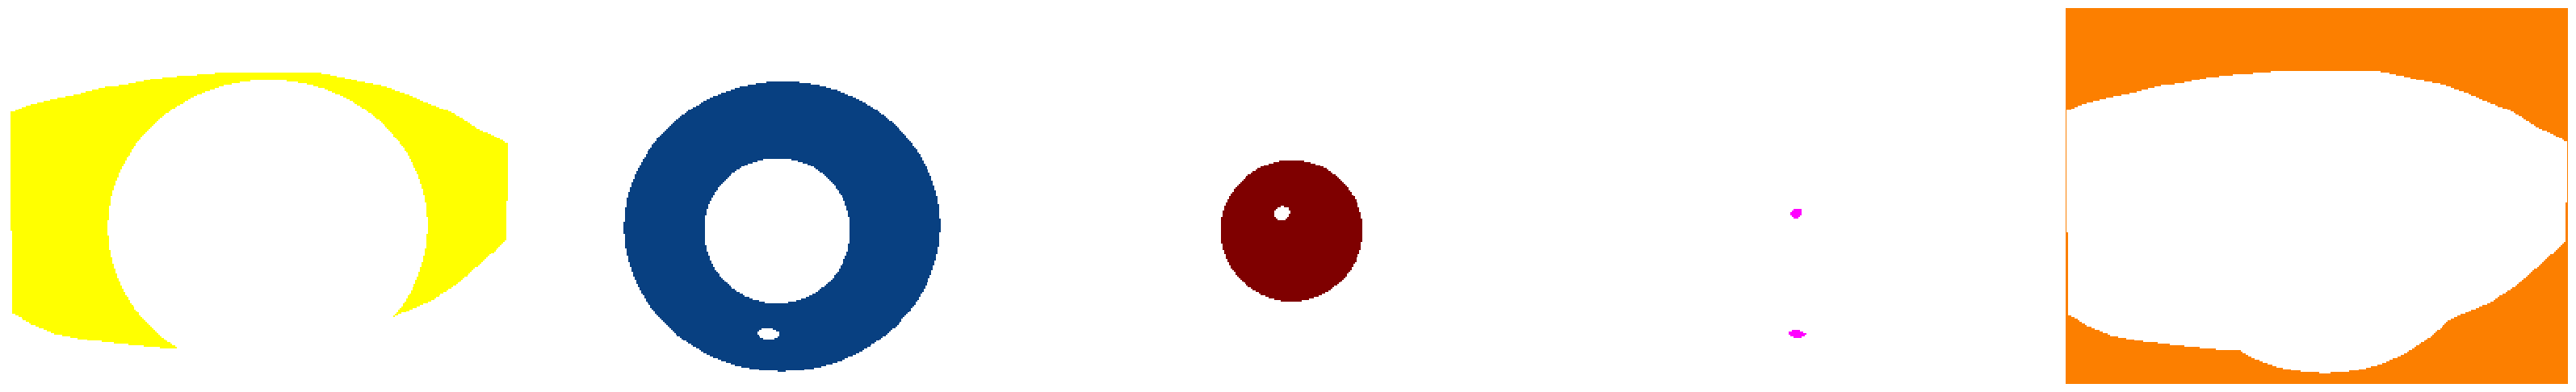

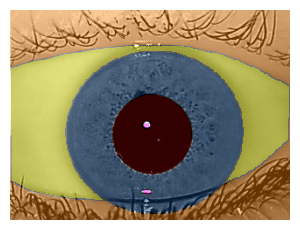

In [6]:
npc = ToNumpy()
check_ds = monai.data.Dataset(data=check_files, transform=train_transforms)
check_loader = DataLoader(
    check_ds, 
    batch_size=10, 
    shuffle=True,
    num_workers=0)
check_data = first(check_loader)
for i in range(1):
    # use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
    # channel first versions
    img_cf = np.squeeze(npc(check_data["img"])[i,:,:,:])
    seg_cf = np.squeeze(npc(check_data["seg"])[i,:,:,:])
    #print("npc(check_data[seg] ", npc(check_data["seg"]).shape)
    #print("seg_cf.shape", seg_cf.shape)
    #print("seg_cf.shape", seg_cf.shape)
    #print (seg_cf)
    # channel last versions for plotting
    pupil_map_masked, iris_map_masked, visible_map_masked, glints_map_masked, irrelevant_map_masked = tuple([np.squeeze(seg_cf[c,:,:]) for c in [0,1,2,3,4]])
    img = np.moveaxis(img_cf, [0,1,2], [-1,-3,-2])
    draw_segmented_areas_separately(img, pupil_map_masked, iris_map_masked, glints_map_masked, visible_map_masked, irrelevant_map_masked)
    draw_segmented_area(img, pupil_map_masked, iris_map_masked, glints_map_masked, visible_map_masked, irrelevant_map_masked)
    #plt.imshow(img)
    #plt.show()

is_overlap_visible_map_masked?  False
is_overlap_iris_map_masked?  False
is_overlap_pupils_map_masked?  False
is_overlap_glint_map_masked?  False
is_overlap_irrelevant_map_masked?  True


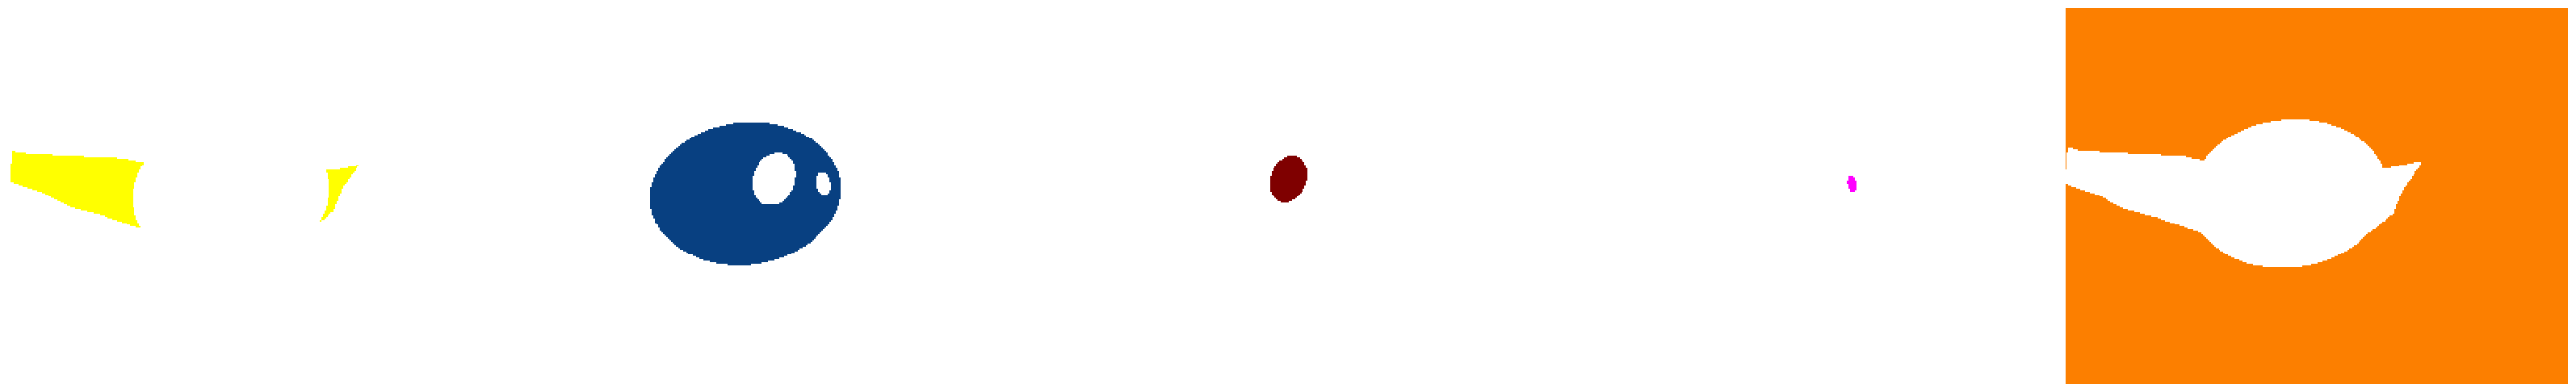

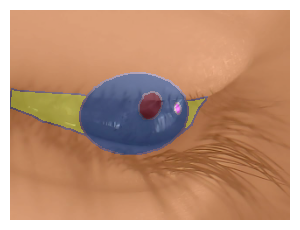

In [29]:
'''
# part to manually separate overlaping after monai transfroms
visible_map_masked = visible_map_masked - iris_map_masked- pupil_map_masked - glints_map_masked
iris_map_masked = iris_map_masked - pupil_map_masked- glints_map_masked
pupil_map_masked = pupil_map_masked - glints_map_masked

visible_map_masked = visible_map_masked.clip(min=0)
iris_map_masked = iris_map_masked.clip(min=0)
pupil_map_masked = pupil_map_masked.clip(min=0)
'''

bin_visible_map_masked = np.where(visible_map_masked > 0.5, True, False)
bin_iris_map_masked = np.where(iris_map_masked > 0.5, True, False)
bin_pupil_map_masked = np.where(pupil_map_masked > 0.5, True, False)
bin_glints_map_masked = np.where(glints_map_masked > 0.5, True, False)
bin_irrelevant_map_masked = np.where(irrelevant_map_masked > 0.5, True, False)

overlap_visible_map_masked = bin_visible_map_masked & (bin_iris_map_masked | bin_pupil_map_masked | bin_glints_map_masked)
overlap_iris_map_masked = bin_iris_map_masked & (bin_visible_map_masked | bin_pupil_map_masked | bin_glints_map_masked)
overlap_pupils_map_masked = bin_pupil_map_masked & (bin_visible_map_masked | bin_iris_map_masked | bin_glints_map_masked)
overlap_glint_map_masked = bin_glints_map_masked & (bin_visible_map_masked | bin_iris_map_masked | bin_pupil_map_masked)
overlap_irrelevant_map_masked = np.logical_not(bin_visible_map_masked | bin_iris_map_masked | bin_pupil_map_masked | bin_glints_map_masked)

is_overlap_visible_map_masked = np.any(overlap_visible_map_masked)
is_overlap_iris_map_masked = np.any(overlap_iris_map_masked)
is_overlap_pupils_map_masked = np.any(overlap_pupils_map_masked)
is_overlap_glint_map_masked = np.any(overlap_glint_map_masked)
is_overlap_irrelevant_map_masked = np.any(overlap_irrelevant_map_masked)

print("is_overlap_visible_map_masked? ", is_overlap_visible_map_masked)
print("is_overlap_iris_map_masked? ", is_overlap_iris_map_masked)
print("is_overlap_pupils_map_masked? ", is_overlap_pupils_map_masked)
print("is_overlap_glint_map_masked? ", is_overlap_glint_map_masked)
print("is_overlap_irrelevant_map_masked? ", is_overlap_irrelevant_map_masked)
                                         
draw_segmented_areas_separately(img, pupil_map_masked, iris_map_masked, glints_map_masked, visible_map_masked, irrelevant_map_masked)
draw_segmented_area(img, pupil_map_masked, iris_map_masked, glints_map_masked, visible_map_masked, irrelevant_map_masked)


In [71]:
# iterate through overlap segmentation to check whether the process of converting one-hot works

def check_overlapping_after_one_hot_conversion():
    check_ds = monai.data.Dataset(data=check_files, transform=train_transforms)
    check_loader = DataLoader(check_ds, batch_size=1, num_workers=0)
    overlapping_indexes = []
    print ("iterating training data")
    for index, check_data in enumerate(check_loader):
        img_cf = np.squeeze(npc(check_data["img"])[i,:,:,:])
        seg_cf = np.squeeze(npc(check_data["seg"])[i,:,:,:])
        pupil_map_masked, iris_map_masked, visible_map_masked, glints_map_masked, irrelevant_map_masked = tuple([np.squeeze(seg_cf[c,:,:]) for c in [0,1,2,3,4]])
        
        bin_visible_map_masked = np.where(visible_map_masked > 0.5, True, False)
        bin_iris_map_masked = np.where(iris_map_masked > 0.5, True, False)
        bin_pupil_map_masked = np.where(pupil_map_masked > 0.5, True, False)
        bin_glints_map_masked = np.where(glints_map_masked > 0.5, True, False)
        bin_irrelevant_map_masked = np.where(irrelevant_map_masked > 0.5, True, False)
        
        isOverlapped = np.any(bin_irrelevant_map_masked 
                              & bin_visible_map_masked 
                              & bin_iris_map_masked 
                              & bin_pupil_map_masked 
                              & bin_glints_map_masked)
        
        notLabeledMatrix = (bin_irrelevant_map_masked 
                                              | bin_visible_map_masked 
                                              | bin_iris_map_masked 
                                              | bin_pupil_map_masked 
                                              | bin_glints_map_masked)
        isNotLabeled = np.any(np.logical_not(notLabeledMatrix))
        
        if (isOverlapped | isNotLabeled):
            overlapping_indexes.append(index)
            if (isNotLabeled):
                print(index)
                print("not labeled pixel")
                print("size", notLabeledMatrix.flatten().shape)
                print("falses", np.sum(np.logical_not(notLabeledMatrix)))
            if (isOverlapped):
                print("overlap")
            print(" ")
            
         
        if (index % (int(len(check_files)/5)) == 0 and index != 0):
            print("%", round(index/len(check_files) *100), " completed")
            
    
    print ("iterating done")
    
    return overlapping_indexes
    
overlapping_indexes = check_overlapping_after_one_hot_conversion()
print(len(overlapping_indexes))


iterating training data
0
not labeled pixel
size (76800,)
falses 326
 
2
not labeled pixel
size (76800,)
falses 209
 
3
not labeled pixel
size (76800,)
falses 949
 
5
not labeled pixel
size (76800,)
falses 827
 
6
not labeled pixel
size (76800,)
falses 573
 
7
not labeled pixel
size (76800,)
falses 421
 
8
not labeled pixel
size (76800,)
falses 501
 
9
not labeled pixel
size (76800,)
falses 323
 
10
not labeled pixel
size (76800,)
falses 511
 
11
not labeled pixel
size (76800,)
falses 725
 
12
not labeled pixel
size (76800,)
falses 183
 
13
not labeled pixel
size (76800,)
falses 962
 
14
not labeled pixel
size (76800,)
falses 715
 
15
not labeled pixel
size (76800,)
falses 440
 
17
not labeled pixel
size (76800,)
falses 597
 
18
not labeled pixel
size (76800,)
falses 892
 
19
not labeled pixel
size (76800,)
falses 239
 
22
not labeled pixel
size (76800,)
falses 368
 
24
not labeled pixel
size (76800,)
falses 843
 
25
not labeled pixel
size (76800,)
falses 559
 
27
not labeled pixel
siz

falses 529
 
191
not labeled pixel
size (76800,)
falses 480
 
192
not labeled pixel
size (76800,)
falses 378
 
193
not labeled pixel
size (76800,)
falses 489
 
194
not labeled pixel
size (76800,)
falses 749
 
195
not labeled pixel
size (76800,)
falses 464
 
197
not labeled pixel
size (76800,)
falses 692
 
198
not labeled pixel
size (76800,)
falses 346
 
199
not labeled pixel
size (76800,)
falses 652
 
200
not labeled pixel
size (76800,)
falses 581
 
202
not labeled pixel
size (76800,)
falses 877
 
203
not labeled pixel
size (76800,)
falses 566
 
204
not labeled pixel
size (76800,)
falses 954
 
205
not labeled pixel
size (76800,)
falses 794
 
206
not labeled pixel
size (76800,)
falses 566
 
207
not labeled pixel
size (76800,)
falses 652
 
208
not labeled pixel
size (76800,)
falses 762
 
209
not labeled pixel
size (76800,)
falses 641
 
210
not labeled pixel
size (76800,)
falses 415
 
211
not labeled pixel
size (76800,)
falses 687
 
212
not labeled pixel
size (76800,)
falses 801
 
213
not

378
not labeled pixel
size (76800,)
falses 672
 
379
not labeled pixel
size (76800,)
falses 430
 
380
not labeled pixel
size (76800,)
falses 1026
 
381
not labeled pixel
size (76800,)
falses 709
 
382
not labeled pixel
size (76800,)
falses 752
 
383
not labeled pixel
size (76800,)
falses 343
 
386
not labeled pixel
size (76800,)
falses 679
 
388
not labeled pixel
size (76800,)
falses 242
 
389
not labeled pixel
size (76800,)
falses 697
 
390
not labeled pixel
size (76800,)
falses 195
 
391
not labeled pixel
size (76800,)
falses 473
 
392
not labeled pixel
size (76800,)
falses 494
 
393
not labeled pixel
size (76800,)
falses 857
 
394
not labeled pixel
size (76800,)
falses 598
 
396
not labeled pixel
size (76800,)
falses 507
 
397
not labeled pixel
size (76800,)
falses 643
 
398
not labeled pixel
size (76800,)
falses 754
 
399
not labeled pixel
size (76800,)
falses 225
 
400
not labeled pixel
size (76800,)
falses 676
 
401
not labeled pixel
size (76800,)
falses 543
 
402
not labeled pix

KeyboardInterrupt: 

In [42]:
# Iterate through fail cases and print their size, whether it's empty. 
# There are some without segmentation, there are some with wrong segmentation/
# For example control images in [575, 873, 1811, 1910, 2116, 2130, 2636, 2705, 2719, 3145, 3403, 4195, 4418, 4619, 4811, 4849, 4899, 4970, 5067, 5247, 5272, 5328, 5441, 5476, 5491]

iris_check_files= np.take(check_files, overlapping_indexes)
check_ds = monai.data.Dataset(data=iris_check_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, num_workers=0)
for index, check_data in enumerate(check_loader):
        img_cf = np.squeeze(npc(check_data["img"])[i,:,:,:])
        seg_cf = np.squeeze(npc(check_data["seg"])[i,:,:,:])
        pupil_map_masked, iris_map_masked, visible_map_masked, glints_map_masked, irrelevant_map_masked= tuple([np.squeeze(seg_cf[c,:,:]) for c in [0,1,2,3,4]])
        
        print("index", overlapping_indexes[index])
        print(iris_map_masked.sum())
        bin_iris_map_masked = np.where(iris_map_masked > 0.5, True, False)
        print(np.any(bin_iris_map_masked))
        print(bin_iris_map_masked.sum())
        print(" ")

index 4
2468.539
True
2445
 
index 14
7258.003
True
7214
 
index 27
3459.1987
True
3452
 
index 36
3126.2864
True
3112
 
index 38
11294.567
True
11284
 
index 56
3045.4314
True
3008
 
index 74
7470.289
True
7450
 
index 76
10566.189
True
10563
 
index 80
3668.7068
True
3641
 
index 93
6482.9844
True
6463
 
index 97
5110.404
True
5025
 
index 112
1583.3792
True
1572
 
index 115
3367.3757
True
3432
 
index 117
2958.2769
True
2933
 
index 139
4780.806
True
4784
 
index 159
3068.7395
True
3103
 
index 210
2927.8438
True
2900
 
index 214
2636.9526
True
2633
 
index 224
17825.291
True
17802
 
index 229
2536.5967
True
2483
 
index 236
13595.088
True
13576
 
index 240
3045.7593
True
3032
 
index 242
7296.9644
True
7201
 
index 261
11705.331
True
11674
 
index 273
7466.842
True
7430
 
index 274
4866.342
True
4858
 
index 281
6568.965
True
6559
 
index 291
1901.0364
True
1866
 
index 330
7783.1333
True
7704
 
index 371
2508.3813
True
2494
 
index 374
5535.1787
True
5534
 
index 379
2514.6313
Tru